In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

In [2]:
df_calendar = pd.read_parquet('data/trusted/training/calendar.parquet')
df_listings = pd.read_parquet('data/trusted/training/listing.parquet')
df_reviews = pd.read_parquet('data/trusted/training/reviews.parquet')

In [3]:
list(df_listings.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30',
 'availa

__Característica da variável resposta__

In [4]:
df_listings.price.quantile([.25, .5, .75, 0.8, 0.9, 0.95, 0.99])

0.25     150.00
0.50     267.00
0.75     533.00
0.80     661.00
0.90    1176.00
0.95    1928.00
0.99    5774.09
Name: price, dtype: float64

In [5]:
df_listings.price.max()

137251.0

Observa-se que a variável resposta está muito concentrada em valores de até 5.7k, enquanto 1% dos valores vão de 5.7k até 137k. É importante para o sucesso do modelo conseguir identificar as caracteríticas desse grupo, segue como essa distribuição se parece

<AxesSubplot:ylabel='Frequency'>

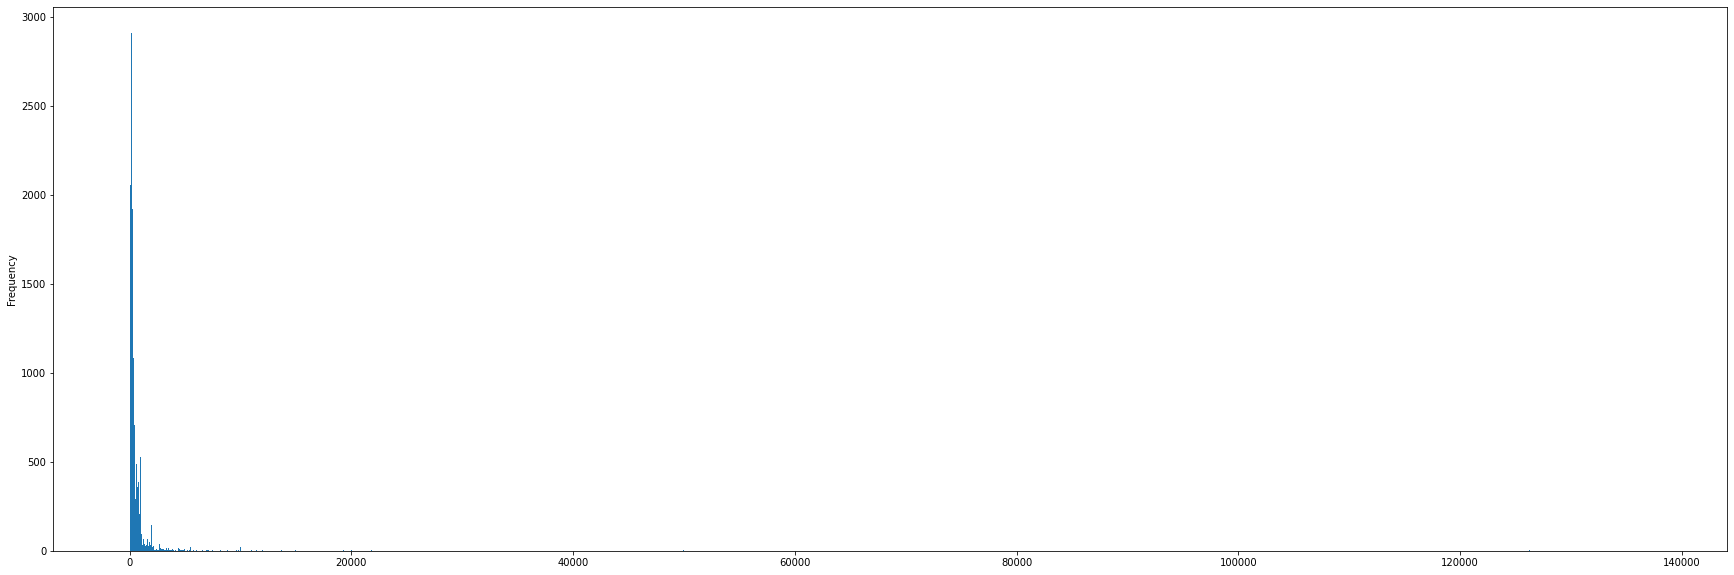

In [6]:
plt.figure(figsize=(30,10))
df_listings.price.plot.hist(bins=3000)

Como cada faixa de preço vem com suas características para o público alvo, vamos separar as faixas de preço entre `comum`, `plus` e `premium`

Entre `comum` e `plus`, podemos cortar no percentile 80%, `< 661.00` e ` >= 661.00`

Já entre `plus` e `premium`, cortaremos no percentile 95%, `< 1928.00` e `>= 1928.00`, uma ponderação entre representatividade e caracterítica.

É necessário achar um meio de diferenciar o seguimento premium dos demais para ajudar o modelo a pelo menos não tentar generalizar os pontos fora da curva.

In [7]:
listing_comum = df_listings[df_listings.price < 661.00].copy().reset_index(drop=True)
listing_comum.shape

(18896, 1311)

In [8]:
listing_plus = df_listings[(df_listings.price >= 661.00) & (df_listings.price < 1928.00)].copy().reset_index(drop=True)
listing_plus.shape

(3547, 1311)

In [9]:
listing_premium = df_listings[df_listings.price >= 1928.00].copy().reset_index(drop=True)
listing_premium.shape

(1185, 1311)

## Hipóteses

### Subprefeituras

In [10]:
def display_category_boxplot(df, col):
    sorted_col = df.groupby(col) \
                   .agg({'price': 'mean'}) \
                   .reset_index() \
                   .sort_values('price', ascending=False) \
                   [col]
    
    display(df.groupby(col) \
              .agg({'price': ['mean', 'std', 'count']}))
    
    plt.xticks(rotation=90)
    sns.boxplot(data=df, x=col, y='price', order=sorted_col)

price                   
                          mean         std  count
subprefeitura                                    
Barra da Tijuca     273.345356  149.740727   4048
Centro              194.367872  138.310208   1631
Grande Bangu        191.815789  171.181562     38
Grande Méier        219.718147  163.679665    259
Grande Tijuca       202.860955  153.290616    712
Ilha do Governador  146.338129  111.532770    139
Sul                 258.972740  145.998399  11702
Zona Norte          162.485714  129.454996    175
Zona Oeste          238.687500  162.782051    192

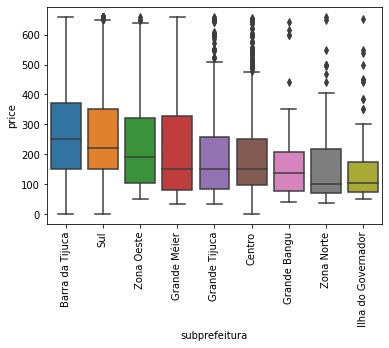

In [11]:
display_category_boxplot(listing_comum, 'subprefeitura')

price                  
                           mean         std count
subprefeitura                                    
Barra da Tijuca     1101.063973  329.986731  1188
Centro              1031.288000  318.920655   125
Grande Bangu        1193.454545  302.431269    11
Grande Méier        1138.515152  322.715540    33
Grande Tijuca       1069.605839  324.054129   137
Ilha do Governador  1224.333333  335.053827     6
Sul                 1058.573226  317.514439  1987
Zona Norte          1044.043478  288.415495    23
Zona Oeste          1007.972973  258.150202    37

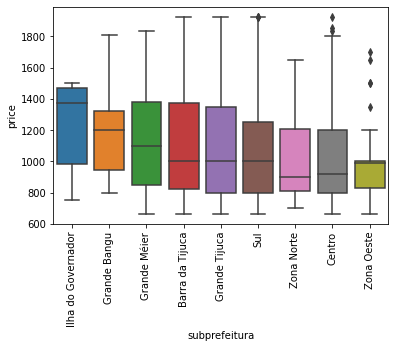

In [12]:
display_category_boxplot(listing_plus, 'subprefeitura')

price                    
                         mean           std count
subprefeitura                                    
Barra da Tijuca   4741.293991   7534.305711   466
Centro            9884.066667  19209.301658    60
Grande Bangu     29097.000000  36490.952550     2
Grande Méier      2727.600000   1557.115378     5
Grande Tijuca     4611.381818   5389.914802    55
Sul               9497.723661  22662.700577   579
Zona Norte        3442.000000   2141.119333     2
Zona Oeste        6728.000000  11504.121511    16

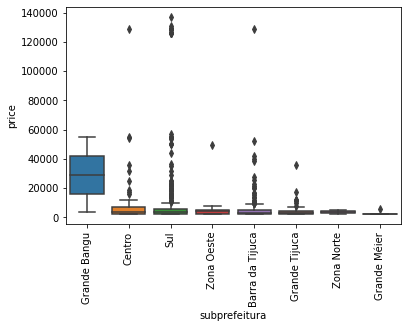

In [13]:
display_category_boxplot(listing_premium, 'subprefeitura')

Das observações podemos concluir que:

1. No seguimento comum, a zona geral é uma boa preditora;
1. A medida que seguimos para valores maiores, a variância de preço aumenta;
1. Duas zonas concentram quase todos anúncios premium: `Barra da Tijuca` e `Zona Sul`.

### Amenities

In [14]:
def count_amenities(df):
    amenities_columns = [col for col in df.columns if 'amenities_' == col[:10]]
    df['num_amenities'] = 0
    for col in amenities_columns:
        df['num_amenities'] += df[col]
    return df

0.2    10.0
0.4    15.0
0.6    20.0
0.8    26.0
Name: num_amenities, dtype: float64

<AxesSubplot:ylabel='Frequency'>

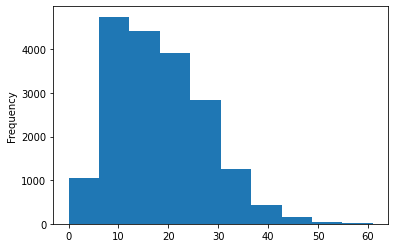

In [15]:
listing_comum = count_amenities(listing_comum)
display(listing_comum['num_amenities'].quantile([0.2, 0.4, 0.6, 0.8]))
listing_comum['num_amenities'].plot.hist()

0.2     9.0
0.4    12.0
0.6    16.0
0.8    22.0
Name: num_amenities, dtype: float64

<AxesSubplot:ylabel='Frequency'>

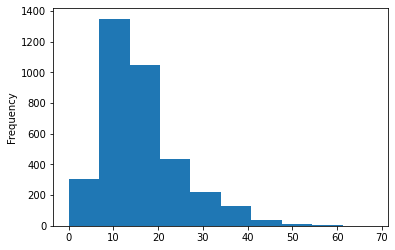

In [16]:
listing_plus = count_amenities(listing_plus)
display(listing_plus['num_amenities'].quantile([0.2, 0.4, 0.6, 0.8]))
listing_plus['num_amenities'].plot.hist()

0.2     9.0
0.4    12.0
0.6    16.0
0.8    21.0
Name: num_amenities, dtype: float64

<AxesSubplot:ylabel='Frequency'>

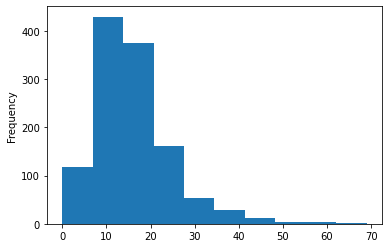

In [17]:
listing_premium = count_amenities(listing_premium)
display(listing_premium['num_amenities'].quantile([0.2, 0.4, 0.6, 0.8]))
listing_premium['num_amenities'].plot.hist()

0.2    10.0
0.4    14.0
0.6    19.0
0.8    26.0
Name: num_amenities, dtype: float64

<AxesSubplot:ylabel='Frequency'>

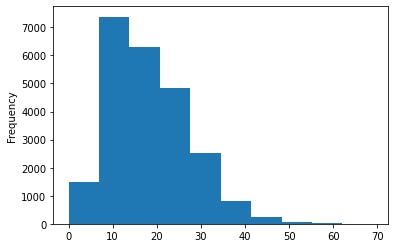

In [18]:
df_listings = count_amenities(df_listings)
display(df_listings['num_amenities'].quantile([0.2, 0.4, 0.6, 0.8]))
df_listings['num_amenities'].plot.hist()

As distribuições de amenities não parecem variar entre os tiers de preço, muito pelo contrário, os anúncios contém uma quantidade maior de até 20 amenidades. Provável que seja um mecanismo de compensação do anunciante querendo chamar atenção nos filtros de busca.

In [24]:
df_count_reviews = df_reviews.groupby('listing_id').agg({'id': 'count'})